In [1]:
import sys
sys.path.append('../')
from KS import KS
from scipy.integrate import odeint
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
from sklearn.decomposition import PCA
import h5py
from pathlib import Path

plt.rcParams.update({
    "text.usetex": True,
    "font.size": '16',
})

In [2]:
ks = KS(L=22.0, K=15, dt=0.01)

In [3]:
pdata = Path('../data/long_trajectory.hdf5')
ppos = Path('../data/5POs_L22.000.hdf5')

try:
    fdata = h5py.File(pdata, 'r')
    sol_ = fdata['sol_'][:, :]
    fdata.close()
except:
    # random trajectory
    np.random.seed(42)
    ic = ks.flow(np.random.randn(ks.d) * 0.01, 100) # transient
    tt = np.arange(0, 10000, 0.01)
    sol = odeint(ks.rhs, ic, tt)
    sol_ = ks.symmreduce(sol)

    fdata = h5py.File(pdata, 'w')

    # gsol = fdata.create_group('sol')
    fdata['sol'] = sol
    fdata['sol_'] = sol_
    fdata.close()

In [4]:
fpos = h5py.File(ppos, 'r')
pos = {}

for ipo, po in enumerate(fpos.keys()):

    pos[po] = {}
    for key in fpos[po].keys():
        pos[po][key] = fpos[po][key][()]
    
    xi_p = pos[po]['xi_p']
    T_p = pos[po]['T_p']
    tt = np.arange(0, T_p, 0.01)
    
    if pos[po]['translation'] and pos[po]['reflection']:
        xi_p = ks.SO2_operator(- pos[po]['phi_p'] / 2) @ xi_p
    
    sol_po = odeint(ks.rhs, xi_p, tt)
    red_sol_po = ks.symmreduce(sol_po)
    pos[po]['sol'] = sol_po
    pos[po]['red_sol'] = red_sol_po
    
fpos.close()

In [5]:
pca = PCA(n_components=3)
pca.fit(sol_)
proj = pca.transform(sol_)
proj_po1 = pca.transform(pos['32.80']['red_sol'])
proj_po2 = pca.transform(pos['43.61']['red_sol'])

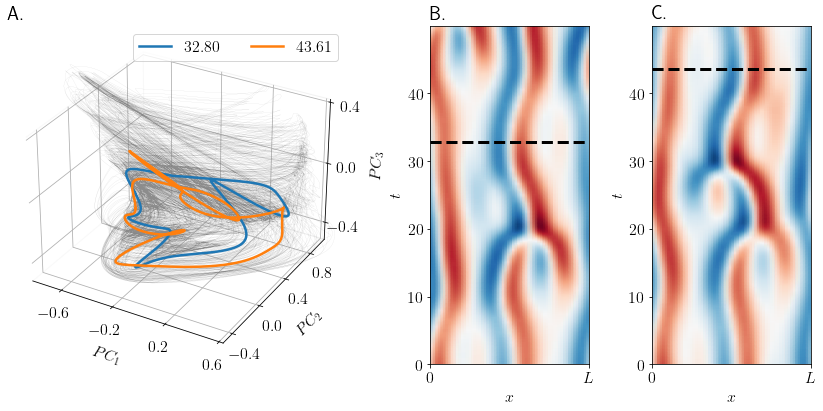

In [10]:
# Create layout
layout = [
    ["A", "A",  "B", "C"],
    ["A", "A",  "B", "C"],
]
fig, axd = plt.subplot_mosaic(layout, figsize=(12,6))

# by default all axes are 2d, below is a hack to make A 3d:
specs = axd['A'].get_subplotspec()
axd['A'].remove()
axd['A'] = fig.add_subplot(specs, projection='3d')
ax = axd['A']

for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
    axis.pane.fill = False

ax.plot(proj[:, 0], proj[:, 1], proj[:, 2], lw=0.06, alpha=0.9, color='gray')
ax.plot(proj_po1[:, 0], proj_po1[:, 1], proj_po1[:, 2], lw=2.5, label='$32.80$')
ax.plot(proj_po2[:, 0], proj_po2[:, 1], proj_po2[:, 2], lw=2.5, label='$43.61$')
ax.set_xlabel("\n$PC_1$")
ax.set_ylabel("\n$PC_2$")
ax.set_zlabel("\n$PC_3$")
ax.set_xlim(-0.8, 0.6)
ax.set_ylim(-0.5, 1.0)
ax.set_zlim(-0.5, 0.4)

ax.set_xticks(np.arange(-0.6, 0.61, 0.4))
ax.set_yticks(np.arange(-0.4, 0.81, 0.4))
ax.set_zticks(np.arange(-0.4, 0.41, 0.4))

ax.legend(ncol=2, loc=1)

tt = np.arange(0, 50, 0.01)
sol_po1 = odeint(ks.rhs, pos['32.80']['xi_p'], tt)
sol_po3 = odeint(ks.rhs, pos['43.61']['xi_p'], tt)

ax = axd['B']
ks.plot_spacetime(sol_po1, tt, ax=ax, vmin=-0.095, vmax=0.095)
ax.plot(
    [0, 22], 
    [pos['32.80']['T_p'], 
     pos['32.80']['T_p']], 
    'k--', lw=3.0
)
ax = axd['C']
ks.plot_spacetime(sol_po3, tt, ax=ax, vmin=-0.095, vmax=0.095)
ax.plot(
    [0, 22], 
    [pos['43.61']['T_p'], 
     pos['43.61']['T_p']], 
    'k--', lw=3.0
)


axd['A'].set_title("A.", loc='left')
axd['B'].set_title("B.", loc='left')
axd['C'].set_title("C.", loc='left')

axd['B'].set_xlabel("$x$")
axd['B'].set_ylabel("$t$")

axd['C'].set_xlabel("$x$")
axd['C'].set_ylabel("$t$")


for ax in [axd['B'], axd['C']]:
    ax.set_xticks([0, 22])
    ax.set_xticklabels(['$0$', '$L$'])

fig.tight_layout()
fig.savefig("../tex/fig/chaosandpos.png", dpi=200)

In [9]:
for po in ['32.80', '43.61']:
    print(f'po_{po}')
    J_p = pos[po]['J_p']
    LA_p, _ = np.linalg.eig(J_p)
    i_sort = np.argsort(np.abs(LA_p))[::-1]
    LA_p = LA_p[i_sort]
    
    print("Multipliers:")
    for ieig in range(4):
        print(f"{np.real(LA_p[ieig]):0.4f} + i {np.imag(LA_p[ieig]):0.4f}")

    print("Exponents:")        
    for ieig in range(4):

        mu = np.log(np.abs(LA_p[ieig])) / T_p 
        om = np.abs(np.angle(LA_p[ieig])) / T_p
        
        print(f"{mu:0.4f} + i {om:0.4f}")

po_32.80
Multipliers:
0.3166 + i 1.8136
0.3166 + i -1.8136
1.0000 + i 0.0000
1.0000 + i 0.0000
Exponents:
0.0128 + i 0.0293
0.0128 + i 0.0293
0.0000 + i 0.0000
0.0000 + i 0.0000
po_43.61
Multipliers:
9.8292 + i 0.0000
1.0000 + i 0.0000
-1.0000 + i 0.0000
0.0908 + i 0.0000
Exponents:
0.0480 + i 0.0000
-0.0000 + i 0.0000
-0.0000 + i 0.0659
-0.0504 + i 0.0000
